In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.mixed_method_0.mixed_method_0_operators import charge_density_two_stream_mixed_method_0
from operators.mixed_method_1.mixed_method_1_operators import extra_term_1
from operators.legendre.legendre_operators import xi_legendre
from operators.hermite.hermite_operators import psi_hermite
from operators.mixed_method_1.setup_mixed_method_1_two_stream import SimulationSetupMixedMethod1
from operators.poisson_solver import gmres_solver
from operators.hermite.hermite_operators import total_mass_hermite, total_momentum_hermite, total_energy_k_hermite
from operators.legendre.legendre_operators import total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

# Mixed method #1: weak Landau damping


In [4]:
setup = SimulationSetupMixedMethod1(Nx=101,
                                    Nv_H=10,
                                    Nv_L=160,
                                    epsilon=1e-2,
                                    v_a=-6,
                                    v_b=6,
                                    alpha=0.8,
                                    u=0,
                                    L=2 * np.pi,
                                    dt=1e-2,
                                    T0=0,
                                    T=50,
                                    nu_L=0,
                                    nu_H=0,
                                    gamma=0,
                                    construct_integrals=False)

In [5]:
if setup.construct_integrals:
    _ = plt.plot(setup.LH_int[:, -1], "-o")
    plt.yscale("symlog", linthresh=1e-5)

In [6]:
if setup.construct_integrals:
    _ = plt.plot(setup.LH_int_complement[:, -1], "-o")
    plt.yscale("symlog", linthresh=1e-5)

In [7]:
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)
v_ = np.linspace(setup.v_a, setup.v_b, 1000, endpoint=True)

# simulation results

In [9]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/mixed_method_1_hermite_legendre/weak_landau/sol_u_NvH_" + str(setup.Nv_H) + "_NvL_" + str(setup.Nv_L) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/mixed_method_1_hermite_legendre/weak_landau/sol_t_NvH_" + str(setup.Nv_H) + "_NvL_" + str(setup.Nv_L) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(17170, 5001)
(5001,)


In [10]:
runtime = np.load("../../data/mixed_method_1_hermite_legendre/weak_landau/sol_runtime_NvH_" + str(setup.Nv_H) + "_NvL_" + str(setup.Nv_L) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([4046.40513   ,  667.87410188])

In [11]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [12]:
# initialize the states for implicit midpoint (symplectic)
state_e_H = np.zeros((setup.Nv_H,  setup.Nx + 1, len(sol_midpoint_t)))
state_e_L = np.zeros((setup.Nv_L,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_e_H[:, :-1, ii]  = np.reshape(sol_midpoint_u[:setup.Nv_H*setup.Nx, ii], (setup.Nv_H, setup.Nx)) 
    state_e_H[:, -1, ii] = state_e_H[:, 0, ii]
    # electrons species 2
    state_e_L[:, :-1, ii]  = np.reshape(sol_midpoint_u[setup.Nv_H*setup.Nx:, ii], (setup.Nv_L, setup.Nx))  
    state_e_L[:, -1, ii] = state_e_L[:, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density_two_stream_mixed_method_0(q_e=setup.q_e, v_a=setup.v_a, v_b=setup.v_b, alpha_e=setup.alpha,
                         C0_e_hermite=state_e_H[0, :setup.Nx, ii], 
                         C0_e_legendre=state_e_L[0, :setup.Nx, ii])
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, a_tol=1e-12, r_tol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

In [13]:
if setup.construct_integrals:
    extra_term = np.zeros((setup.Nx*setup.Nv_L, len(sol_midpoint_t)))
    for ii in range(len(sol_midpoint_t)):
        extra_term[:, ii] =  extra_term_1(LH_int_1=setup.LH_int[:, -1],
                                           v_b=setup.v_b,
                                           v_a=setup.v_a,
                                           C_hermite_last=state_e_H[-1, :-1, ii],
                                           alpha=setup.alpha,
                                           Nv_H=setup.Nv_H,
                                           D=setup.D,
                                           E=E_midpoint[:-1, ii], 
                                           Nv_L=setup.Nv_L, 
                                           Nx=setup.Nx)

In [14]:
if setup.construct_integrals:
    # plot the electric field
    fig, ax = plt.subplots(figsize=(6, 3))
    pos = ax.contourf(np.arange(len(extra_term)), sol_midpoint_t, extra_term.T, cmap="viridis", levels=30)
    cbar = fig.colorbar(pos)
    ax.set_title(r"$- \frac{A}{v_{b} - v_{a}}  \int_{v_{a}}^{v_{b}} \psi_{N_{H}} \xi_{m} \mathrm{d} v$")
    ax.set_xlabel("$x$")
    # _ = ax.set_xticks([0, 10*np.pi/3, 20*np.pi/3-.05])
    # _ = ax.set_xticklabels([r"0", r"$10\pi/3$", r"$20\pi/3$"])
    _ = ax.set_ylabel("$t$")
    plt.tight_layout()

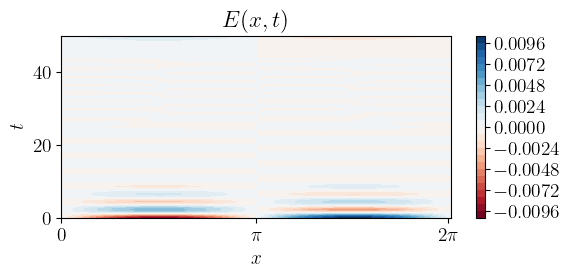

In [15]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

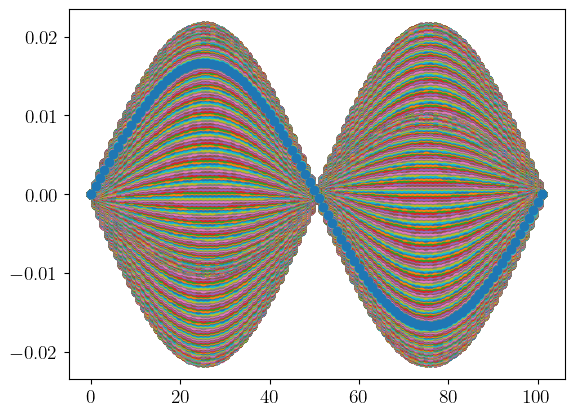

In [16]:
_ = plt.plot(state_e_H[-1, :, :], "-o")

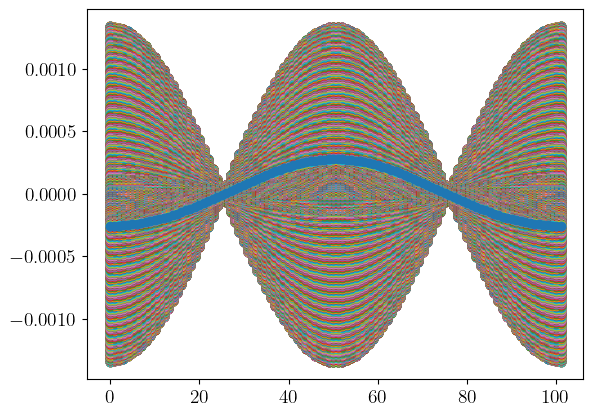

In [17]:
_ = plt.plot(state_e_L[0, :, :], "-o")

In [18]:
np.save("../../data/mixed_method_1_hermite_legendre/weak_landau/E1_Nv_V3_" + str(setup.Nv_H + setup.Nv_L) + ".npy", np.abs(np.fft.fft(E_midpoint, axis=0, norm="forward")[1, :]))

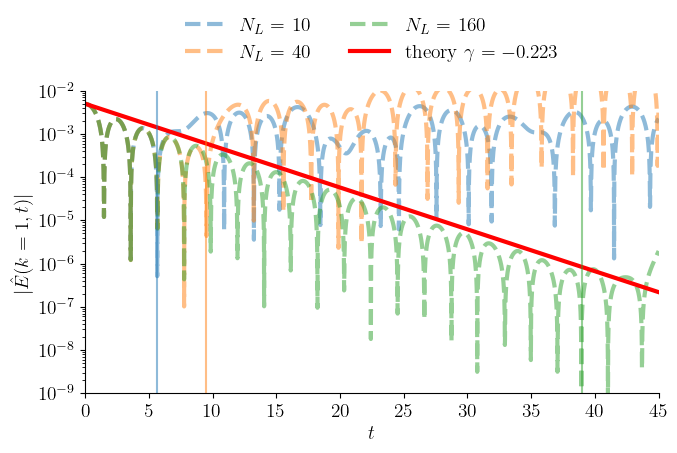

In [23]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 5))
for Nv in [10+10, 40+10, 160+10]:
    E1 = np.load("../../data/mixed_method_1_hermite_legendre/weak_landau/E1_Nv_V3_" + str(Nv) + ".npy")
    ax.plot(sol_midpoint_t, E1, "--", alpha=0.5, linewidth=3, label="$N_{L}$ = " + str(Nv-10)) 
    
ax.plot(sol_midpoint_t, 0.005*np.exp(-0.223*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = -0.223$") 


ax.axvline(5.6, color="tab:blue", alpha=0.5)
ax.axvline(9.5, color="tab:orange", alpha=0.5)
ax.axvline(39, color="tab:green", alpha=0.5)


ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(k=1, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, 45)
ax.set_ylim(1e-9, 1e-2)
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3))
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/weak_landau/weak_landau_damping_mm1_V3.png", dpi=300)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_55282/1346376874.py:2: RuntimeWarning: divide by zero encountered in log10
  pos = ax.pcolormesh(np.arange(setup.Nv_H), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_H[:, :-1, :], axis=1, norm="forward")[:, 1, :])).T, vmin=-6, vmax=-1)


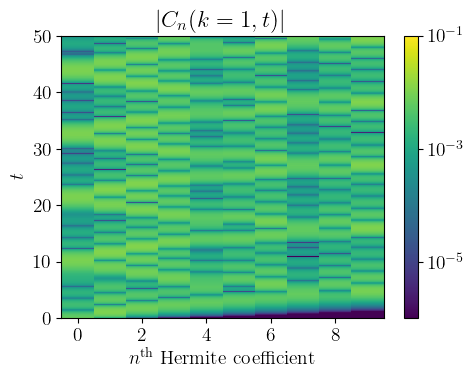

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))
pos = ax.pcolormesh(np.arange(setup.Nv_H), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_H[:, :-1, :], axis=1, norm="forward")[:, 1, :])).T, vmin=-6, vmax=-1)
cbar = fig.colorbar(pos)
cbar.set_ticks([-1, -3, -5])
cbar.set_ticklabels(['$10^{-1}$', '$10^{-3}$', '$10^{-5}$'])

ax.set_ylabel("$t$")
ax.set_xlabel("$n^{\mathrm{th}}$ Hermite coefficient")
ax.set_title("$|C_{n}(k=1, t)|$")
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/nonlinear_landau/hermite_evolution_mixed_method_1.png", dpi=600)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_55282/2115989726.py:2: RuntimeWarning: divide by zero encountered in log10
  pos = ax.pcolormesh(np.arange(setup.Nv_L), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_L[:, :-1, :], axis=1, norm="forward"))[:, 1, :]).T, vmin=-12, vmax=5)


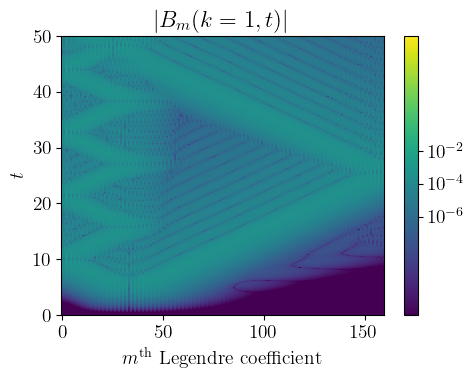

In [21]:
fig, ax = plt.subplots(figsize=(5,4))
pos = ax.pcolormesh(np.arange(setup.Nv_L), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_L[:, :-1, :], axis=1, norm="forward"))[:, 1, :]).T, vmin=-12, vmax=5)
cbar = fig.colorbar(pos)
cbar.set_ticks([-2, -4, -6])
cbar.set_ticklabels(['$10^{-2}$',  '$10^{-4}$', '$10^{-6}$'])

ax.set_ylabel("$t$")
ax.set_xlabel("$m^{\mathrm{th}}$ Legendre coefficient")
ax.set_title("$|B_{m}(k=1, t)|$")
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/nonlinear_landau/legendre_evolution_mixed_method_1.png", dpi=600)

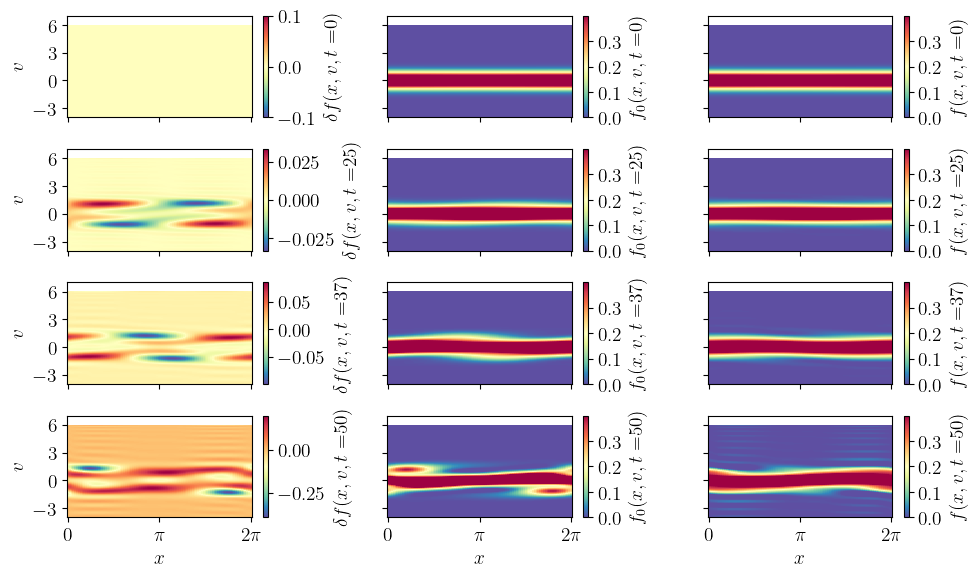

In [59]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 6), sharex=True, sharey=True)

levels = np.linspace(-0.05, 0.4, 50)

for tt, ii in enumerate([0, len(sol_midpoint_t)//2, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution1 = np.zeros((len(x), len(v_)))
    distribution2 = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_H):
        distribution1 += np.outer(state_e_H[jj, :, ii], psi_hermite(v=v_, u_s=setup.u, alpha_s=setup.alpha, n=jj))
    for jj in range(setup.Nv_L):
        distribution2 += np.outer(state_e_L[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
    pos2 = ax[tt, 0].pcolormesh(x, v_, distribution2.T, cmap="Spectral_r")
    pos1 = ax[tt, 1].pcolormesh(x, v_, distribution1.T, cmap="Spectral_r", vmin=0, vmax=0.4)
    pos3 = ax[tt, 2].pcolormesh(x, v_, distribution1.T + distribution2.T, cmap="Spectral_r", vmin=0, vmax=0.4)
    ax[tt, 0].set_yticks([-3, 0, 3, 6])
    ax[tt, 0].set_ylim(-4, 7)
    ax[tt, 0].set_ylabel("$v$")
    cbar = fig.colorbar(pos1)
    cbar.ax.set_ylabel('$f_{0}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])

    cbar = fig.colorbar(pos2)
    cbar.ax.set_ylabel('$\delta f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)


    cbar = fig.colorbar(pos3)
    cbar.ax.set_ylabel('$f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
    
ax[tt, 0].set_xlabel("$x$")
ax[tt, 0].set_xticks([0, np.pi, 2*np.pi])
ax[tt, 0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[tt, 2].set_xlabel("$x$")
ax[tt, 1].set_xlabel("$x$")
ax[tt, 1].set_xticks([0, np.pi, 2*np.pi])
ax[tt, 1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])

plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/bump_on_tail/bump_on_tail_evolution_mixed_method_1.png", dpi=600)

In [59]:
Nv_vec_mm1 = [20, 40, 60, 80, 100, 200, 300, 400]
recurrence_vec_mm1 = [5, 6, 7.5, 9, 10, 11, 15, 18]

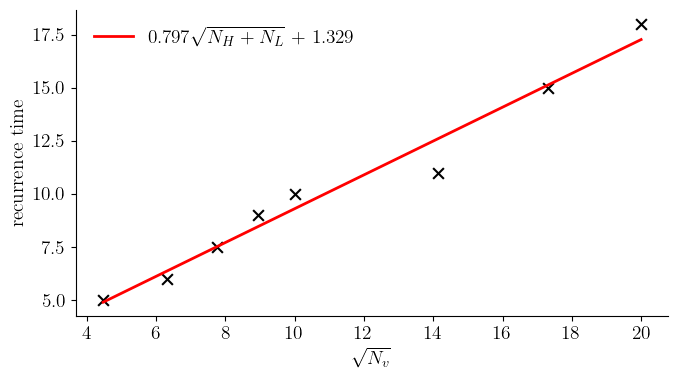

In [60]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(np.sqrt(Nv_vec_mm1), recurrence_vec_mm1, marker="x", s=60, color="black")

slope, intercept = np.polyfit(np.sqrt(Nv_vec_mm1), recurrence_vec_mm1, 1)
ax.plot(np.sqrt(Nv_vec_mm1), slope*np.sqrt(Nv_vec_mm1) + intercept, color="red", linewidth=2, label=str(round(slope, 3)) + "$\sqrt{N_{H} + N_{L}}$ + " + str(round(intercept, 3)))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("recurrence time")
ax.set_xlabel("$\sqrt{N_{v}}$")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='upper left')
legend.get_frame().set_alpha(0)
plt.tight_layout()
#plt.savefig("../../figures/mixed_method_1/weak_landau/weak_landau_damping_recurrence_time_hermite.png", dpi=300)

# conservation laws: mass, momentum, and energy

### mass conservation

In [ ]:
# compute mass at each timestamp
mass_midpoint_H = np.zeros(len(sol_midpoint_t))
mass_midpoint_L = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint_H[ii] = total_mass_hermite(state=state_e_H[:, :-1, ii], alpha_s=setup.alpha, dx=setup.dx)
    mass_midpoint_L[ii] = total_mass_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)

mass_midpoint = mass_midpoint_L + mass_midpoint_H

In [ ]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, mass_midpoint_H - mass_midpoint_H[0], "-", label="Hermite")
ax.plot(sol_midpoint_t, mass_midpoint_L - mass_midpoint_L[0], ":", label="Legendre")
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "--", label="total")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.legend()
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [ ]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_hermite(state=state_e_H[:, :-1, ii], alpha_s=setup.alpha, u_s=setup.u,
                                                   dx=setup.dx, m_s=setup.m_e)\
                            +total_momentum_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)

In [ ]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [ ]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_hermite(state=state_e_H[:, :-1, ii], alpha_s=setup.alpha, u_s=setup.u, dx=setup.dx, m_s=setup.m_e)\
                           +total_energy_k_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

In [ ]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

In [ ]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$t$")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

In [ ]:
# plot the analytic and numerical conservation properties
skip = 5

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=3, fontsize=14, loc='upper center')
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.tight_layout()